In [262]:
import sys
sys.path.insert(0, '..')

import torch
import os
import wandb
import random
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup
from torch.utils.data import DataLoader
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from tqdm import tqdm
from matplotlib import cm
import seaborn as sns
import matplotlib.lines as mlines
from sklearn.decomposition import PCA
from openTSNE import TSNE
from PIL import Image

from core.final.dataset import PSMDataset
from core.final.model import GalSpecNet, MetaModel, Informer, AstroModel
from core.final.trainer import Trainer

In [2]:
def get_model(config):
    if config['mode'] == 'photo':
        model = Informer(config)
    elif config['mode'] == 'spectra':
        model = GalSpecNet(config)
    elif config['mode'] == 'meta':
        model = MetaModel(config)
    else:
        model = AstroModel(config)

    return model

In [237]:
run_id = 'MeriDK/AstroCLIPResults3/2wz4ysvn'
api = wandb.Api()
run = api.run(run_id)
config = run.config
config['use_wandb'] = False

In [238]:
test_dataset = PSMDataset(config, split='test')
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = get_model(config)
model = model.to(device)

In [279]:
weights_path = os.path.join(config['weights_path'] + '-' + run_id.split('/')[-1], f'weights-best.pth')
model.load_state_dict(torch.load(weights_path, weights_only=False))

model.eval()
p_embs, s_embs, m_embs, labels = [], [], [], []

with torch.no_grad():
    for photometry, photometry_mask, spectra, metadata, label in test_dataloader:
        photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
        spectra, metadata = spectra.to(device), metadata.to(device)

        p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)
        p_embs.append(p_emb.cpu())
        s_embs.append(s_emb.cpu())
        m_embs.append(m_emb.cpu())
        labels.append(label)

p_embs = torch.vstack(p_embs)
s_embs = torch.vstack(s_embs)
m_embs = torch.vstack(m_embs)
labels = torch.hstack(labels)

In [280]:
p_embs.shape, s_embs.shape, m_embs.shape

(torch.Size([2225, 512]), torch.Size([2225, 512]), torch.Size([2225, 512]))

In [281]:
combined_embs = torch.vstack([p_embs, s_embs, m_embs])
combined_embs.shape

torch.Size([6675, 512])

In [ ]:
tsne = TSNE(n_components=2, metric='cosine', n_jobs=16, random_state=42, verbose=True)
embs_2d = tsne.fit(combined_embs)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, metric='cosine', n_jobs=16, random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 9.24 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.07 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.09 seconds
===> Running optimization with exaggeration=12.00, lr=556.25 for 250 iterations...
Iteration   50, KL divergence 3.9555, 50 iterations in 1473.4786 sec
Iteration  100, KL divergence 3.6743, 50 iterations in 718.0820 sec
Iteration  150, KL divergence 3.6464, 50 iterations in 458.5194 sec
Iteration  200, KL divergence 3.6248, 50 iterations in 480.9246 sec
Iteration  250, KL divergence 3.6113, 50 iterations in 1148.7991 sec
   --> Time elapsed: 4279.81 seconds
===> Runnin

In [ ]:
class_freq = test_dataset.df['target'].value_counts()
sorted_classes = class_freq.index

id2target = test_dataset.id2target
target2id = test_dataset.target2id

palette = sns.color_palette("tab20", len(id2target))
marker_size = 12

x_min, x_max = np.min(embs_2d[:, 0]) - 5, np.max(embs_2d[:, 0]) + 5
y_min, y_max = np.min(embs_2d[:, 1]) - 5, np.max(embs_2d[:, 1]) + 5

In [ ]:
size = len(test_dataset)
p_embs_2d = embs_2d[:size]
s_embs_2d = embs_2d[size:size * 2]
m_embs_2d = embs_2d[size * 2:]

plt.figure(figsize=(10, 8))

# Plot P embeddings with triangles
for class_name in sorted_classes:
    class_id = target2id[class_name]  # Use target2id to get numeric class ID
    class_mask = labels == class_id
    plt.scatter(p_embs_2d[class_mask, 0], p_embs_2d[class_mask, 1], 
                color=palette[class_id], label=class_name, alpha=0.7, s=marker_size, marker='^')

# Plot S embeddings with squares
for class_name in sorted_classes:
    class_id = target2id[class_name]
    class_mask = labels == class_id
    plt.scatter(s_embs_2d[class_mask, 0], s_embs_2d[class_mask, 1], 
                color=palette[class_id], alpha=0.7, s=marker_size, marker='s')

# Plot M embeddings with circles
for class_name in sorted_classes:
    class_id = target2id[class_name]
    class_mask = labels == class_id
    plt.scatter(m_embs_2d[class_mask, 0], m_embs_2d[class_mask, 1], 
                color=palette[class_id], alpha=0.7, s=marker_size, marker='o')

# Create legends for colors (classes)
handles_colors = [mlines.Line2D([], [], color=palette[i], marker='o', linestyle='None', markersize=8, 
                  label=id2target[class_id]) for i, class_id in enumerate(np.unique(labels))]
color_legend = plt.legend(handles=handles_colors, loc='upper right', fontsize=10, title="Classes")

# Create legends for shapes (embeddings)
handles_shapes = [
    mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=8, label='Photometry', markerfacecolor='white'),
    mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=8, label='Spectra', markerfacecolor='white'),
    mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Metadata', markerfacecolor='white')
]

plt.legend(handles=handles_shapes, loc='upper left', fontsize=10, title="Embeddings")

# Add the color legend back to the plot
plt.gca().add_artist(color_legend)
plt.title(f"Epoch Best")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
# plt.savefig(f"plots/tsne_cos_p500{weights[epoch]}.png", dpi=300, bbox_inches='tight')
plt.show()

In [243]:
weights = []

for file in os.listdir(config['weights_path'] + '-' + run_id.split('/')[-1]):
    epoch = file.split('.')[0].split('-')[-1]

    if epoch != 'best':
        weights.append(int(epoch))

In [244]:
weights.sort()

In [245]:
all_embs = {}

for w in tqdm(weights):
    weights_path = os.path.join(config['weights_path'] + '-' + run_id.split('/')[-1], f'weights-{w}.pth')
    model.load_state_dict(torch.load(weights_path, weights_only=False))

    model.eval()
    p_embs, s_embs, m_embs, labels = [], [], [], []

    with torch.no_grad():
        for photometry, photometry_mask, spectra, metadata, label in test_dataloader:
            photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
            spectra, metadata = spectra.to(device), metadata.to(device)
    
            p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)
            p_embs.append(p_emb.cpu())
            s_embs.append(s_emb.cpu())
            m_embs.append(m_emb.cpu())
            labels.append(label)
    
    p_embs = torch.vstack(p_embs)
    s_embs = torch.vstack(s_embs)
    m_embs = torch.vstack(m_embs)
    labels = torch.hstack(labels)

    all_embs[w] = (p_embs, s_embs, m_embs, labels)

100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [45:32<00:00, 30.70s/it]


In [246]:
all_embs[0][0].shape

torch.Size([2225, 512])

In [247]:
combined_embs = [all_embs[i][j] for i in all_embs for j in range(3)]
combined_embs = torch.vstack(combined_embs)

In [248]:
combined_embs.shape

torch.Size([594075, 512])

In [249]:
# three times for each modality
combined_labels = [all_embs[i][-1] for i in all_embs for j in range(3)]
combined_labels = torch.hstack(combined_labels)

In [250]:
combined_labels.shape

torch.Size([594075])

In [255]:
pca = PCA(n_components=128, random_state=42)
reduced_embs = pca.fit_transform(combined_embs)

In [256]:
pca.explained_variance_ratio_.sum()

0.9886376191744018

In [273]:
tsne = TSNE(n_components=2, metric='cosine', perplexity=500, n_jobs=16, random_state=42, verbose=True)
embs_2d = tsne.fit(reduced_embs)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, metric='cosine', n_jobs=16, perplexity=500,
     random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 1500 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 680.15 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 146.84 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.47 seconds
===> Running optimization with exaggeration=12.00, lr=49506.25 for 250 iterations...
Iteration   50, KL divergence 5.1786, 50 iterations in 91.7669 sec
Iteration  100, KL divergence 4.9642, 50 iterations in 92.0028 sec
Iteration  150, KL divergence 4.7516, 50 iterations in 91.5617 sec
Iteration  200, KL divergence 4.6478, 50 iterations in 91.4430 sec
Iteration  250, KL divergence 4.6072, 50 iterations in 91.0965 sec
   --> Time elapsed: 457.88 sec

In [274]:
embs_2d.shape

(594075, 2)

In [275]:
class_freq = test_dataset.df['target'].value_counts()
sorted_classes = class_freq.index

id2target = test_dataset.id2target
target2id = test_dataset.target2id

palette = sns.color_palette("tab20", len(id2target))
marker_size = 12

x_min, x_max = np.min(embs_2d[:, 0]) - 5, np.max(embs_2d[:, 0]) + 5
y_min, y_max = np.min(embs_2d[:, 1]) - 5, np.max(embs_2d[:, 1]) + 5

In [ ]:
for epoch in range(len(weights)):
    size = len(test_dataset)
    embds0 = embs_2d[epoch * size * 3:(epoch + 1) * size * 3]
    p_embs0 = embds0[:size]
    s_embs0 = embds0[size:size * 2]
    m_embs0 = embds0[size * 2:size * 3]
    labels0 = combined_labels[:size]
    
    plt.figure(figsize=(10, 8))
    
    # Plot P embeddings with triangles
    for class_name in sorted_classes:
        class_id = target2id[class_name]  # Use target2id to get numeric class ID
        class_mask = labels0 == class_id
        plt.scatter(p_embs0[class_mask, 0], p_embs0[class_mask, 1], 
                    color=palette[class_id], label=class_name, alpha=0.7, s=marker_size, marker='^')
    
    # Plot S embeddings with squares
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = labels0 == class_id
        plt.scatter(s_embs0[class_mask, 0], s_embs0[class_mask, 1], 
                    color=palette[class_id], alpha=0.7, s=marker_size, marker='s')
    
    # Plot M embeddings with circles
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = labels0 == class_id
        plt.scatter(m_embs0[class_mask, 0], m_embs0[class_mask, 1], 
                    color=palette[class_id], alpha=0.7, s=marker_size, marker='o')
    
    # Create legends for colors (classes)
    handles_colors = [mlines.Line2D([], [], color=palette[i], marker='o', linestyle='None', markersize=8, 
                                    label=id2target[class_id]) for i, class_id in enumerate(np.unique(labels))]
    color_legend = plt.legend(handles=handles_colors, loc='upper right', fontsize=10, title="Classes")
    
    # Create legends for shapes (embeddings)
    handles_shapes = [
        mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=8, label='Photometry', markerfacecolor='white'),
        mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=8, label='Spectra', markerfacecolor='white'),
        mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Metadata', markerfacecolor='white')
    ]
    
    plt.legend(handles=handles_shapes, loc='upper left', fontsize=10, title="Embeddings")
    
    # Add the color legend back to the plot
    plt.gca().add_artist(color_legend)
    plt.title(f"Epoch {weights[epoch]}")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.savefig(f"plots/tsne_cos_p500{weights[epoch]}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [277]:
image_files = [f"plots/tsne_cos_p500{weights[epoch]}.png" for epoch in range(len(weights))]
images = [Image.open(img) for img in image_files]

In [278]:
images[0].save(
    "plots/tsne_cos_p500_animation.gif",
    save_all=True,
    append_images=images[1:],
    duration=200,  # duration between frames in milliseconds
    loop=0  # loop forever
)

In [150]:
for w in tqdm(weights):
    weights_path = os.path.join(config['weights_path'] + '-' + run_id.split('/')[-1], f'weights-{w}.pth')
    model.load_state_dict(torch.load(weights_path, weights_only=False))

    model.eval()
    p_embs, s_embs, m_embs, labels = [], [], [], []
    
    with torch.no_grad():
        for photometry, photometry_mask, spectra, metadata, label in test_dataloader:
            photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
            spectra, metadata = spectra.to(device), metadata.to(device)
    
            p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)
            p_embs.append(p_emb.cpu())
            s_embs.append(s_emb.cpu())
            m_embs.append(m_emb.cpu())
            labels.append(label)
    
    p_embs = torch.vstack(p_embs)
    s_embs = torch.vstack(s_embs)
    m_embs = torch.vstack(m_embs)
    labels = torch.hstack(labels)

    combined_embs = np.concatenate([p_embs, s_embs, m_embs], axis=0)
    combined_labels = np.concatenate([labels, labels, labels], axis=0)
    
    tsne = TSNE(n_components=2, random_state=42)
    embs_2d = tsne.fit_transform(combined_embs)

    p_embs_2d = embs_2d[:p_embs.shape[0]]
    s_embs_2d = embs_2d[p_embs.shape[0]:p_embs.shape[0] + s_embs.shape[0]]
    m_embs_2d = embs_2d[p_embs.shape[0] + s_embs.shape[0]:]
    
    # Sort unique labels based on class frequency (most common first)
    class_freq = test_dataset.df['target'].value_counts()
    sorted_classes = class_freq.index
    
    # Dictionary for converting numeric labels to actual class names
    id2target = test_dataset.id2target
    target2id = test_dataset.target2id
    
    # Use Seaborn color palette to get distinct colors
    palette = sns.color_palette("tab20", len(id2target))
    marker_size = 12
    
    plt.figure(figsize=(10, 8))
    
    # Plot P embeddings with triangles
    for class_name in sorted_classes:
        class_id = target2id[class_name]  # Use target2id to get numeric class ID
        class_mask = labels == class_id
        plt.scatter(p_embs_2d[class_mask, 0], p_embs_2d[class_mask, 1], 
                    c label=class_name, alpha=0.7, s=marker_size, marker='^')
    
    # Plot S embeddings with squares
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = labels == class_id
        plt.scatter(s_embs_2d[class_mask, 0], s_embs_2d[class_mask, 1], 
                    color=palette[class_id], alpha=0.7, s=marker_size, marker='s')
    
    # Plot M embeddings with circles
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = labels == class_id
        plt.scatter(m_embs_2d[class_mask, 0], m_embs_2d[class_mask, 1], 
                    color=palette[class_id], alpha=0.7, s=marker_size, marker='o')
    
    # Create legends for colors (classes)
    handles_colors = [mlines.Line2D([], [], color=palette[i], marker='o', linestyle='None', markersize=8, 
                                    label=id2target[class_id]) for i, class_id in enumerate(np.unique(labels))]
    color_legend = plt.legend(handles=handles_colors, loc='upper right', fontsize=10, title="Classes")
    
    # Create legends for shapes (embeddings)
    handles_shapes = [
        mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=8, label='Photometry', markerfacecolor='white'),
        mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=8, label='Spectra', markerfacecolor='white'),
        mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Metadata', markerfacecolor='white')
    ]
    
    plt.legend(handles=handles_shapes, loc='upper left', fontsize=10, title="Embeddings")
    
    # Add the color legend back to the plot
    plt.gca().add_artist(color_legend)
    plt.title(f"Epoch {w}")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.savefig(f"plots/tsne_{w}.png", dpi=300, bbox_inches='tight')
    # plt.show()

  0%|                                                                                           | 0/36 [01:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
weights_path = os.path.join(config['weights_path'] + '-' + run_id.split('/')[-1], f'weights-best.pth')
model.load_state_dict(torch.load(weights_path, weights_only=False))

In [100]:
model.eval()
p_embs, s_embs, m_embs, labels = [], [], [], []

with torch.no_grad():
    for photometry, photometry_mask, spectra, metadata, label in tqdm(test_dataloader):
        photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
        spectra, metadata = spectra.to(device), metadata.to(device)

        p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)
        p_embs.append(p_emb.cpu())
        s_embs.append(s_emb.cpu())
        m_embs.append(m_emb.cpu())
        labels.append(label)

p_embs = torch.vstack(p_embs)
s_embs = torch.vstack(s_embs)
m_embs = torch.vstack(m_embs)
labels = torch.hstack(labels)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.45s/it]


In [91]:
combined_embs = np.concatenate([p_embs, s_embs, m_embs], axis=0)
combined_labels = np.concatenate([labels, labels, labels], axis=0)

tsne = TSNE(n_components=2, random_state=42)
embs_2d = tsne.fit_transform(combined_embs)

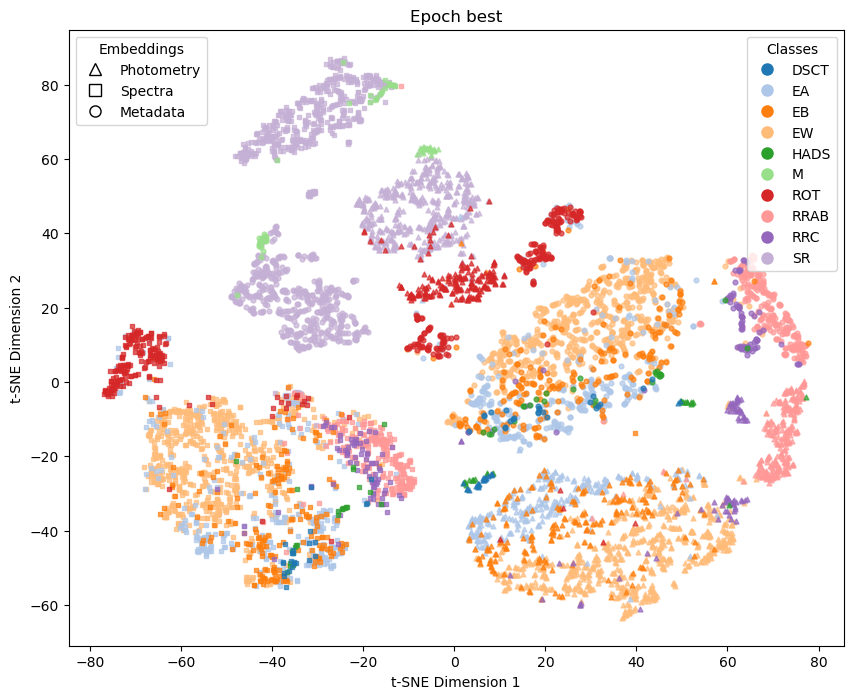

In [134]:
p_embs_2d = embs_2d[:p_embs.shape[0]]
s_embs_2d = embs_2d[p_embs.shape[0]:p_embs.shape[0] + s_embs.shape[0]]
m_embs_2d = embs_2d[p_embs.shape[0] + s_embs.shape[0]:]

# Sort unique labels based on class frequency (most common first)
class_freq = test_dataset.df['target'].value_counts()
sorted_classes = class_freq.index

# Dictionary for converting numeric labels to actual class names
id2target = test_dataset.id2target
target2id = test_dataset.target2id

# Use Seaborn color palette to get distinct colors
palette = sns.color_palette("tab20", len(id2target))
marker_size = 12

plt.figure(figsize=(10, 8))

# Plot P embeddings with triangles
for class_name in sorted_classes:
    class_id = target2id[class_name]  # Use target2id to get numeric class ID
    class_mask = labels == class_id
    plt.scatter(p_embs_2d[class_mask, 0], p_embs_2d[class_mask, 1], 
                color=palette[class_id], label=class_name, alpha=0.7, s=marker_size, marker='^')

# Plot S embeddings with squares
for class_name in sorted_classes:
    class_id = target2id[class_name]
    class_mask = labels == class_id
    plt.scatter(s_embs_2d[class_mask, 0], s_embs_2d[class_mask, 1], 
                color=palette[class_id], alpha=0.7, s=marker_size, marker='s')

# Plot M embeddings with circles
for class_name in sorted_classes:
    class_id = target2id[class_name]
    class_mask = labels == class_id
    plt.scatter(m_embs_2d[class_mask, 0], m_embs_2d[class_mask, 1], 
                color=palette[class_id], alpha=0.7, s=marker_size, marker='o')

# Create legends for colors (classes)
handles_colors = [mlines.Line2D([], [], color=palette[i], marker='o', linestyle='None', markersize=8, 
                                label=id2target[class_id]) for i, class_id in enumerate(np.unique(labels))]
color_legend = plt.legend(handles=handles_colors, loc='upper right', fontsize=10, title="Classes")

# Create legends for shapes (embeddings)
handles_shapes = [
    mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=8, label='Photometry', markerfacecolor='white'),
    mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=8, label='Spectra', markerfacecolor='white'),
    mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Metadata', markerfacecolor='white')
]

plt.legend(handles=handles_shapes, loc='upper left', fontsize=10, title="Embeddings")

# Add the color legend back to the plot
plt.gca().add_artist(color_legend)
plt.title(f"Epoch {'best'}")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.savefig("plots/tsne_plot.png", dpi=300, bbox_inches='tight')
plt.show()

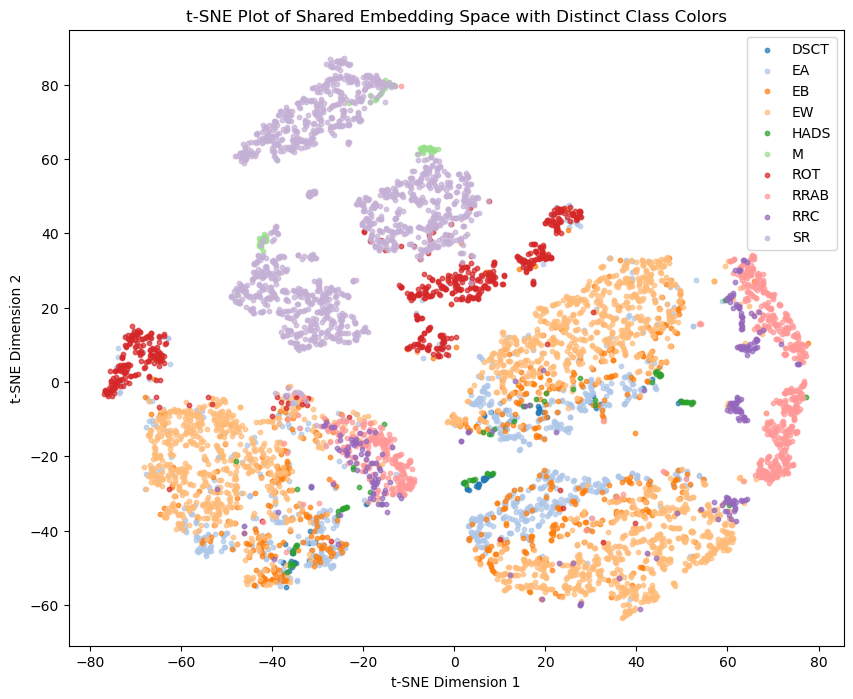

In [109]:
# Create a distinct color for each class
unique_classes = np.unique(combined_labels)
palette = sns.color_palette("tab20", len(test_dataset.id2target))

plt.figure(figsize=(10, 8))

# Plot each class with a distinct color
for i, class_id in enumerate(np.unique(combined_labels)):
    class_mask = combined_labels == class_id
    plt.scatter(embs_2d[class_mask, 0], embs_2d[class_mask, 1], 
                color=palette[i], label=test_dataset.id2target[class_id], alpha=0.7, s=10)

# Add legends for distinct classes
plt.legend()
plt.title("t-SNE Plot of Shared Embedding Space with Distinct Class Colors")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

In [94]:
# Split the t-SNE result back to individual embedding sets
p_embs_2d = embs_2d[:p_embs.shape[0]]
s_embs_2d = embs_2d[p_embs.shape[0]:p_embs.shape[0] + s_embs.shape[0]]
m_embs_2d = embs_2d[p_embs.shape[0] + s_embs.shape[0]:]

In [95]:
id2target = test_dataset.id2target

In [97]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
labels, class_id

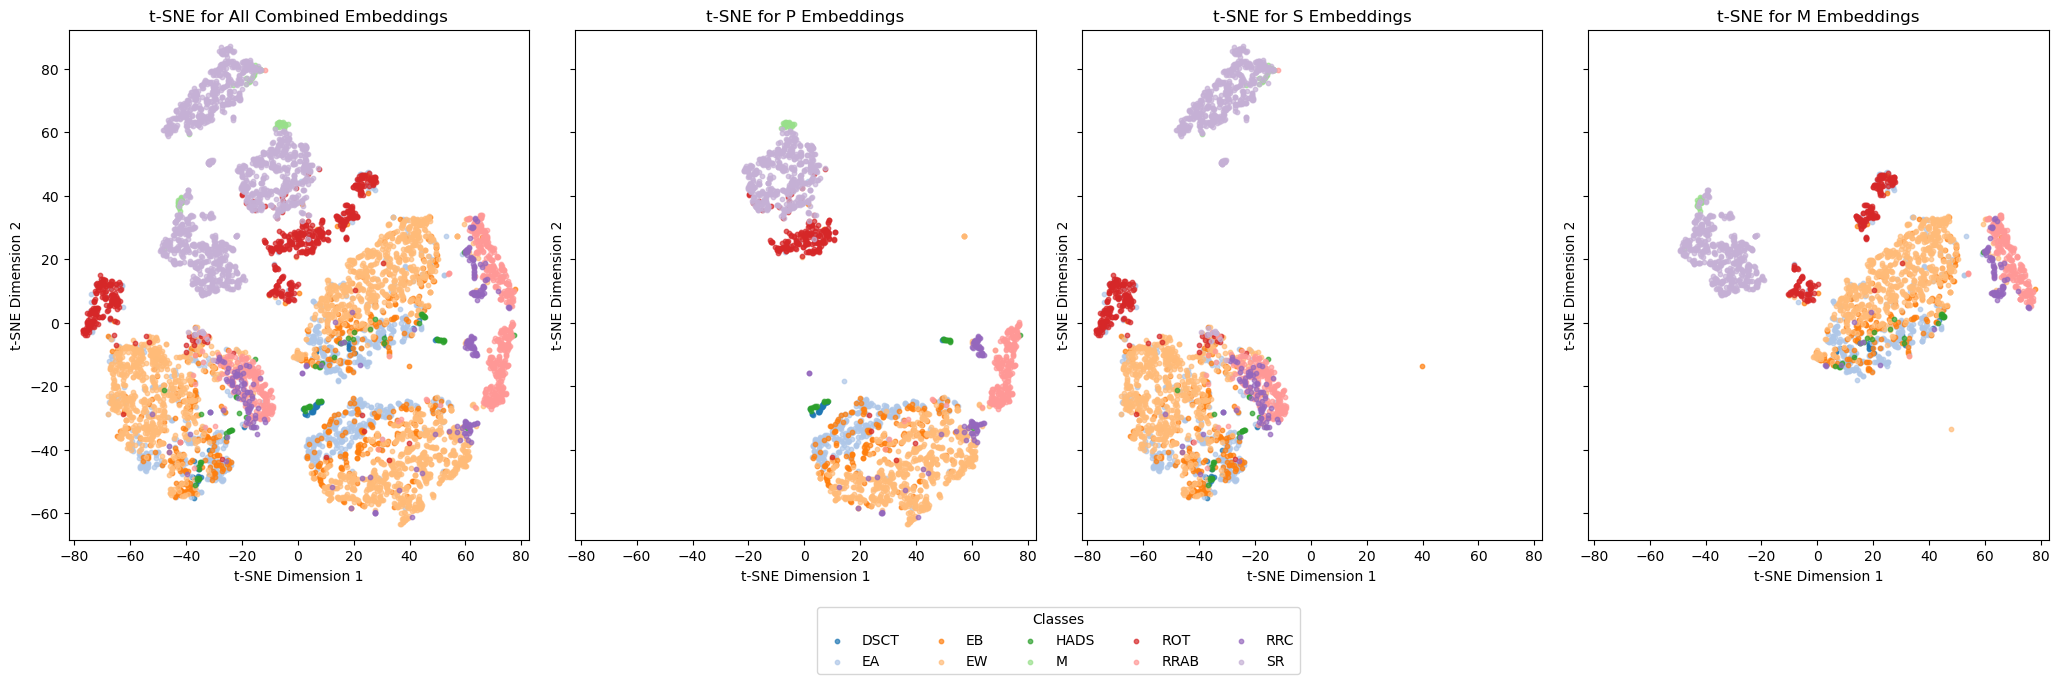

In [107]:
# Get the axis limits from the combined embeddings
x_min, x_max = np.min(embs_2d[:, 0]) - 5, np.max(embs_2d[:, 0]) + 5
y_min, y_max = np.min(embs_2d[:, 1]) - 5, np.max(embs_2d[:, 1]) + 5

# Function to plot t-SNE for a given embedding set and add legend
def plot_tsne(ax, embeddings_2d, labels, title):
    for i, class_id in enumerate(np.unique(labels)):
        class_mask = labels == class_id
        ax.scatter(embeddings_2d[class_mask, 0], embeddings_2d[class_mask, 1], 
                   color=palette[i], label=id2target[class_id], alpha=0.7, s=10)
    
    ax.set_title(title)
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    
    # Set the same limits for all plots
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

# Create subplots for the 4 plots
fig, axes = plt.subplots(1, 4, figsize=(22, 6), sharex=True, sharey=True)

# Plot for all combined embeddings
plot_tsne(axes[0], embs_2d, combined_labels, "t-SNE for All Combined Embeddings")

# Plot for p_embs
plot_tsne(axes[1], p_embs_2d, labels, "t-SNE for P Embeddings")

# Plot for s_embs
plot_tsne(axes[2], s_embs_2d, labels, "t-SNE for S Embeddings")

# Plot for m_embs
plot_tsne(axes[3], m_embs_2d, labels, "t-SNE for M Embeddings")

# Add a single legend outside the plot
handles, legend = axes[0].get_legend_handles_labels()  # Get legend elements
fig.legend(handles, legend, loc='upper center', fontsize=10, title="Classes", bbox_to_anchor=(0.5, -0.05), ncol=5)

# Adjust layout to make space for the legend and prevent overlap
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.05, wspace=0.1)

# Show the plots
plt.show()

In [55]:
# Combine embeddings into one array
all_embs = np.vstack([p_embs, s_embs, m_embs])  # Shape: (6675, 512)

# Create an array indicating which embedding each row came from
embedding_types = np.array(['p'] * 2225 + ['s'] * 2225 + ['m'] * 2225)

# Duplicate labels accordingly
all_labels = np.tile(labels, 3)  # Shape: (6675,)

# Compute TSNE embeddings over all embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
all_embs_tsne = tsne.fit_transform(all_embs)  # Shape: (6675, 2)

# Split TSNE embeddings back into individual embeddings
p_embs_tsne = all_embs_tsne[0:2225]
s_embs_tsne = all_embs_tsne[2225:4450]
m_embs_tsne = all_embs_tsne[4450:]

# Define a color map for labels
unique_labels = np.unique(labels_np)
num_classes = len(unique_labels)
cmap = plt.get_cmap('tab10')  # Adjust if you have more than 10 classes

# Function to map labels to colors
def get_colors(labels):
    color_dict = {label: idx for idx, label in enumerate(unique_labels)}
    colors = [color_dict[label] for label in labels]
    return colors

# Plot TSNE embeddings for each embedding type
def plot_tsne(embs_tsne, labels, title):
    colors = get_colors(labels)
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(embs_tsne[:, 0], embs_tsne[:, 1], c=colors, cmap=cmap, alpha=0.6)
    # Create a legend with unique labels
    handles, _ = scatter.legend_elements()
    legend_labels = [str(label) for label in unique_labels]
    plt.legend(handles, legend_labels, title="Classes", loc='best')
    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.grid(True)
    plt.show()

/global/home/users/mariia/miniforge3/envs/astro/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Plot TSNE embeddings for each embedding type
plot_tsne(p_embs_tsne, labels_np, 'TSNE of p_embs')
plot_tsne(s_embs_tsne, labels_np, 'TSNE of s_embs')
plot_tsne(m_embs_tsne, labels_np, 'TSNE of m_embs')